#  <center> Speech Emotion Recognition <center>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [2]:
# Paths for data.
Crema = "AudioWAV - Organised - Copy/"
crema_folder_list = os.listdir(Crema)

## <center>2. Crema DataFrame</center>

In [3]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for i in range(0, 3):
    crema_directory_list = os.listdir(Crema + crema_folder_list[i])

    for file in crema_directory_list:
        # storing file paths
        file_path.append(Crema + crema_folder_list[i] + "/" + file)
        # storing file emotions
        part = [x.strip() for x in file.split('-')]

        if part[0] == 'Sad':
            file_emotion.append('sad')
        elif part[0] == 'Anger':
            file_emotion.append('angry')
        elif part[0] == 'Disgust':
            file_emotion.append('disgust')
        elif part[0] == 'Fear':
            file_emotion.append('fear')
        elif part[0] == 'Happy':
            file_emotion.append('happy')
        elif part[0] == 'Neutral':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,AudioWAV - Organised - Copy/The airplane is al...
1,disgust,AudioWAV - Organised - Copy/The airplane is al...
2,happy,AudioWAV - Organised - Copy/The airplane is al...
3,disgust,AudioWAV - Organised - Copy/The airplane is al...
4,angry,AudioWAV - Organised - Copy/The airplane is al...


In [4]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Crema_df], axis = 0)
data_path.to_csv("data_path.csv", index=False)
data_path.head()

# Extracting data and sample_rate
path = np.array(data_path.Path)[0]
data, sample_rate = librosa.load(path)

# Functions
def getEmotion(path):
    part = path.split('_')
    if part[2] == 'SAD':
        return "sad"
    elif part[2] == 'ANG':
        return "angry"
    elif part[2] == 'DIS':
        return "disgust"
    elif part[2] == 'FEA':
        return "fear"
    elif part[2] == 'HAP':
        return "happy"
    elif part[2] == 'NEU':
        return "neutral"
    else:
        return "unknown"

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# Feature extraction functions
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))  # stacking vertically

    return result

In [5]:

X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

len(X), len(Y), data_path.Path.shape

Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv("my_features.csv", index=False)

/var/folders/vn/xwnfpg5x38j0c4r46tln8vlm0000gn/T/ipykernel_42209/2576939424.py:42: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
/var/folders/vn/xwnfpg5x38j0c4r46tln8vlm0000gn/T/ipykernel_42209/2576939424.py:49: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [42]:
Features = pd.read_csv("my_features.csv")

X = Features.iloc[:,:-1].values
Y = Features['labels'].values

# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True,test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3931, 162, 1), (3931, 6), (983, 162, 1), (983, 6))

## Modelling

In [32]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 81, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 41, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 21, 128)         

In [33]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
mc = ModelCheckpoint(filepath='best_models', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history=model.fit(x_train, y_train, batch_size=64, epochs=228, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/228
62/62 [==============================] - 7s 95ms/step - loss: 1.7154 - accuracy: 0.2473 - val_loss: 1.6337 - val_accuracy: 0.2920 - lr: 0.0010
Epoch 2/228
62/62 [==============================] - 6s 91ms/step - loss: 1.6359 - accuracy: 0.2880 - val_loss: 1.5902 - val_accuracy: 0.3255 - lr: 0.0010
Epoch 3/228
62/62 [==============================] - 6s 91ms/step - loss: 1.5702 - accuracy: 0.3243 - val_loss: 1.5346 - val_accuracy: 0.3398 - lr: 0.0010
Epoch 4/228
62/62 [==============================] - 6s 92ms/step - loss: 1.5268 - accuracy: 0.3500 - val_loss: 1.5487 - val_accuracy: 0.3540 - lr: 0.0010
Epoch 5/228
62/62 [==============================] - 6s 92ms/step - loss: 1.5145 - accuracy: 0.3544 - val_loss: 1.4982 - val_accuracy: 0.3540 - lr: 0.0010
Epoch 6/228
62/62 [==============================] - 6s 95ms/step - loss: 1.4989 - accuracy: 0.3699 - val_loss: 1.4409 - val_accuracy: 0.3845 - lr: 0.0010
Epoch 7/228
62/62 [==============================] - 6s 97ms/step - lo

In [36]:
model.save("speech_emotion_new.h5")

In [37]:
# serialize model to JSON
model_json = model.to_json()
with open("speech_emotion_new.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("speech_emotion_weight_new.h5")

31/31 [==============================] - 0s 14ms/step - loss: 2.8231 - accuracy: 0.5219
Accuracy of our model on test data :  52.187180519104004 %


ValueError: x and y must have same first dimension, but have shapes (50,) and (100,)

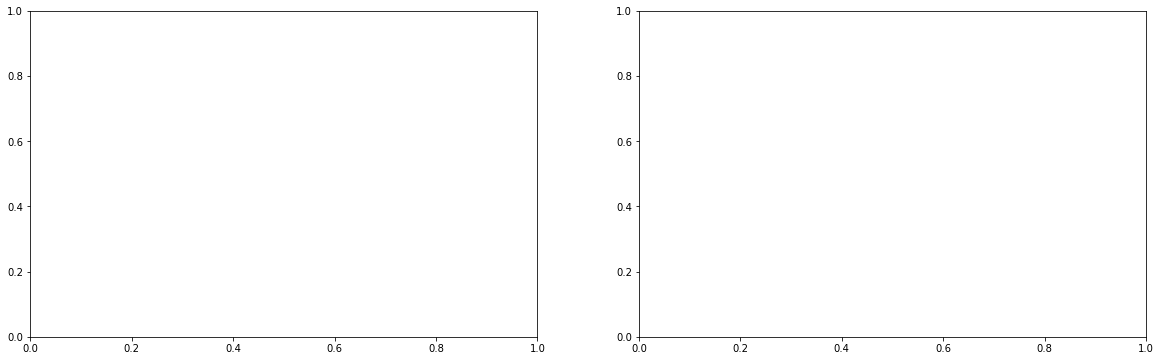

In [8]:
# Print model accuracy
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [43]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,sad,neutral
1,angry,angry
2,happy,happy
3,fear,happy
4,happy,happy
5,sad,sad
6,fear,neutral
7,happy,fear
8,sad,neutral
9,fear,happy


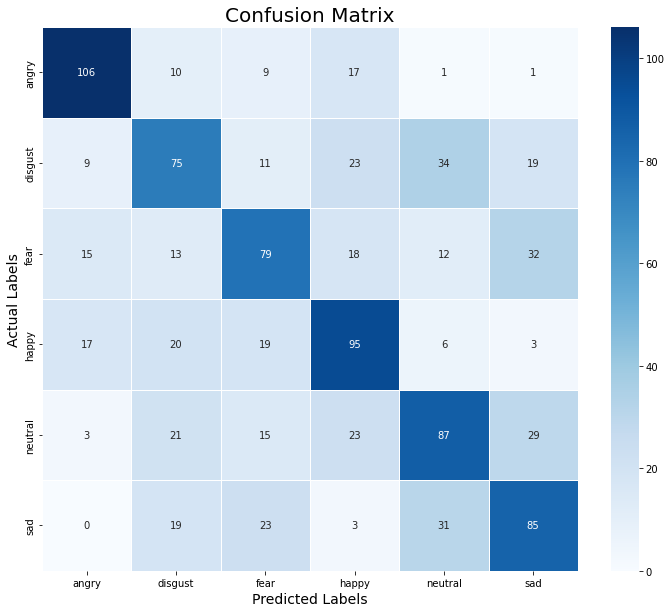

              precision    recall  f1-score   support

       angry       0.71      0.74      0.72       144
     disgust       0.47      0.44      0.46       171
        fear       0.51      0.47      0.49       169
       happy       0.53      0.59      0.56       160
     neutral       0.51      0.49      0.50       178
         sad       0.50      0.53      0.52       161

    accuracy                           0.54       983
   macro avg       0.54      0.54      0.54       983
weighted avg       0.53      0.54      0.53       983



In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

print(classification_report(y_test, y_pred))